In [1]:
import mdtraj as md
from glob import glob
import pyemma
import numpy as np
from simtk import unit

In [2]:
# time between saved snapshots
# (see variable `thinning` in `bayes_implicit_solvent/vacuum_samples/prepare_vacuum_samples.py`
# and variable `stepsize` in `bayes_implicit_solvent/solvation_free_energy.py`)
thinning_interval = 1000 * unit.femtosecond

In [3]:
traj_names = glob('../bayes_implicit_solvent/vacuum_samples/*.h5')
len(traj_names)

642

Potentially also include torsion features if I'm feeling fancy:

```python
def get_torsion_tuples(traj):
    """dumb brute-force O(n_bonds^3) iteration"""
    
    bonds = list([sorted((a.index, b.index)) for (a,b) in traj.top.bonds])
    torsions = []
    for bond1 in bonds:
        for bond2 in bonds:
            for bond3 in bonds:
                if (bond1[1] == bond2[0]) and (bond2[1] == bond3[0]):
                    torsions.append((bond1[0], bond1[1], bond2[1], bond3[1]))
    return torsions

def estimate_timescales(traj, lag=20, max_features=1500):
    """apply tICA to all pairwise distances and torsion angles and return timescale estimates"""
    feat = pyemma.coordinates.featurizer(traj.topology)
    feat.add_distances(np.arange(traj.n_atoms))
    feat.add_dihedrals(get_torsion_tuples(traj))
    
    if len(feat.describe()) > max_features:
        print("Warning! max_features exceeded ({} > {}), skipping this one and returning nans...".format(len(feat.describe()), max_features))
        return np.nan * np.zeros(max_features)
    
    X = feat.transform(traj)
    tica = pyemma.coordinates.tica(X, lag=lag)
    return tica.timescales```

In [4]:
def get_pairs(n):
    """exclude redundancies"""
    pairs = []
    for i in range(n):
        for j in range(i):
            pairs.append((i,j))
    return pairs
    
def estimate_timescales(traj, lag=20):
    """apply tICA to all pairwise distances and return timescale estimates"""
    pairs = get_pairs(traj.n_atoms)
    
    feat = pyemma.coordinates.featurizer(traj.topology)
    feat.add_distances(pairs)
    
    X = feat.transform(traj)
    tica = pyemma.coordinates.tica(X, lag=lag)
    return tica.timescales

In [5]:
timescales = []
from tqdm import tqdm
for traj_name in tqdm(traj_names):
    timescales.append(estimate_timescales(md.load(traj_name)))

100%|██████████| 642/642 [02:24<00:00,  4.45it/s]


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
traj = md.load(traj_names[0])

Text(0.5,1,'estimated mixing times as a fraction of simulation length')

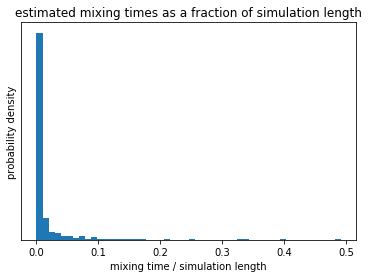

In [13]:
# what's the distribution of estimated mixing times, as a fraction of the simulation length?

mixing_times = np.array([t[0] for t in timescales])
plt.hist(mixing_times / len(traj), bins=50);
plt.xlabel('mixing time / simulation length')
plt.ylabel('probability density')
plt.yticks([])
plt.title('estimated mixing times as a fraction of simulation length')

trajectory with slowest mixing time:  ../bayes_implicit_solvent/vacuum_samples/vacuum_samples_42.h5
# atoms:  28


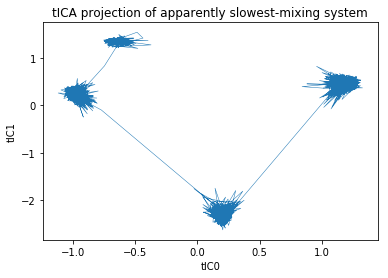

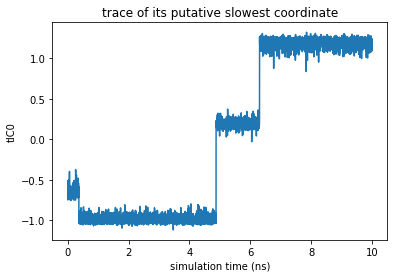

In [14]:
# Let's look more closely at the slowest-mixing system
index_of_slowest_one = np.argmax(mixing_times)
print('trajectory with slowest mixing time: ', traj_names[index_of_slowest_one])
traj = md.load(traj_names[index_of_slowest_one])
pairs = get_pairs(traj.n_atoms)

feat = pyemma.coordinates.featurizer(traj.topology)
feat.add_distances(pairs)

X = feat.transform(traj)
tica = pyemma.coordinates.tica(X, lag=20)
y = tica.get_output()[0]

plt.plot(y[:,0], y[:,1], linewidth=0.5)
plt.xlabel('tIC0')
plt.ylabel('tIC1')
plt.title('tICA projection of apparently slowest-mixing system')

plt.figure()
t = np.arange(len(y)) * thinning_interval / unit.nanosecond
plt.plot(t, y[:,0])
plt.xlabel('simulation time (ns)')
plt.ylabel('tIC0')
plt.title('trace of its putative slowest coordinate')

print('# atoms: ', traj.n_atoms)

trajectory with fastest mixing time:  ../bayes_implicit_solvent/vacuum_samples/vacuum_samples_640.h5
# atoms:  3


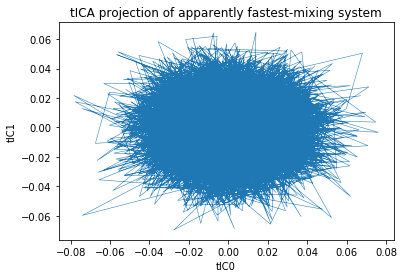

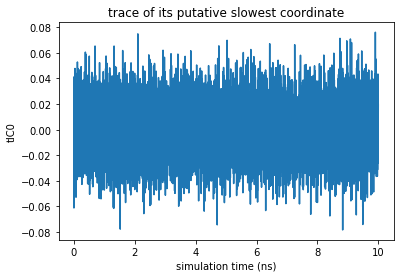

In [15]:
# And at the fastest-mixing system
index_of_fastest_one = np.argmin(mixing_times)
print('trajectory with fastest mixing time: ', traj_names[index_of_fastest_one])
traj = md.load(traj_names[index_of_fastest_one])
pairs = get_pairs(traj.n_atoms)

feat = pyemma.coordinates.featurizer(traj.topology)
feat.add_distances(pairs)

X = feat.transform(traj)
tica = pyemma.coordinates.tica(X, lag=20)
y = tica.get_output()[0]

plt.plot(y[:,0], y[:,1], linewidth=0.5)
plt.xlabel('tIC0')
plt.ylabel('tIC1')
plt.title('tICA projection of apparently fastest-mixing system')

plt.figure()
t = np.arange(len(y)) * thinning_interval / unit.nanosecond
plt.plot(t, y[:,0])
plt.xlabel('simulation time (ns)')
plt.ylabel('tIC0')
plt.title('trace of its putative slowest coordinate')

print('# atoms: ', traj.n_atoms)

In [16]:
# what was the median?
np.median(mixing_times / len(traj))

0.003446557932809739

In [17]:
# what fraction of simulations were at least 10x longer than estimated mixing time?
np.mean((mixing_times / len(traj)) < 0.1)

0.9704049844236761

In [18]:
# what fraction of simulations were at least 100x longer than estimated mixing time?
np.mean((mixing_times / len(traj)) < 0.01)

0.7601246105919003

In [19]:
# what fraction of simulations were at least 1x longer than estimated mixing time?
np.mean((mixing_times / len(traj)) < 1.0)

1.0

In [ ]:
# okay, should probably go back and run at least a few of these simulations much longer